# Importing The Libraries

In [ ]:
import numpy as np
import pandas as pd
import datetime
import matplotlib 
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt, numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import AgglomerativeClustering
from matplotlib.colors import ListedColormap
from sklearn import metrics
import warnings
import sys
if not sys.warnoptions:
  warnings.simplefilter("ignore")
np.random.seed(42)

# Loading Data

In [ ]:
# Loading the dataset 
data = pd.read_csv("marketing_campaign.csv", sep="\t")
print("Number of datapoints: ", len(data))
data.head()

Number of datapoints:  2240


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0


# Data Cleaning 

* Data Cleaning 
* Feature Engineering 

In [ ]:
# Information on features
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

* There are missing values in income
* Dt_Customer that indicates the data a customer joined the database is not parsed as DateTime
* There are some categorical features in our data framel as there are some features in dtype: object. So we will need to encode them into numeric forms later.

In [ ]:
# Removing rows with missing Income values
data = data.dropna()
print("The total number of data-points after removing the rows with missing values are:", len(data
                                                                                              ))

The total number of data-points after removing the rows with missing values are: 2216


In [ ]:
# Creating feature from "Dt_Customer" that indicates
# the number of days a customer is regsitered in the firm's database.
# Taking this value relative to the most recent customer

In [ ]:
data["Dt_Customer"] = pd.to_datetime(data["Dt_Customer"])
dates = []
for i in data["Dt_Customer"]:
  i = i.date()
  dates.append(i)
# Dates of the newest and oldest recorded customer
print("The newest customer's enrolment date in the records: ", max(dates))
print("The oldest customer's enrolment date in the records: ", min(dates))

The newest customer's enrolment date in the records:  2014-12-06
The oldest customer's enrolment date in the records:  2012-01-08


### Creating a feature ("Customer For") of the number of days the customers started to shop in the store relative to the last recorded date

In [ ]:
# Created a feature "Customer_For"
days = []
d1 = max(dates) # taking it to be the newest customer
for i in dates:
  delta = d1 - i
  days.append(delta)
data["Customer_For"] = days
data["Customer_For"] = pd.to_numeric(data["Customer_For"], errors='coerce')

In [ ]:
print("Total categories in the feature Marital_Status:\n",
      data["Marital_Status"].value_counts(), "\n")
print("Total categories in the feature Education:\n",
      data["Education"].value_counts())

Total categories in the feature Marital_Status:
 Married     857
Together    573
Single      471
Divorced    232
Widow        76
Alone         3
YOLO          2
Absurd        2
Name: Marital_Status, dtype: int64 

Total categories in the feature Education:
 Graduation    1116
PhD            481
Master         365
2n Cycle       200
Basic           54
Name: Education, dtype: int64


## Feature Engineering 

In [ ]:
# Age of customer today
data["Age"] = 2021 - data["Year_Birth"]

In [ ]:
# Total spending on various items
data["Spent"] = data["MntWines"] + data["MntFruits"] + data["MntMeatProducts"] + data["MntFishProducts"] + data["MntSweetProducts"] + data["MntGoldProds"]

In [ ]:
# Deriving living situation by marital status "Alone"
data["Living_With"] = data["Marital_Status"].replace({
    "Married":"Partner", "Together":"Partner", 
    "Absurd":"Alone", "Widow":"Alone", "YOLO":"Alone",
    "Divorced":"Alone", "Single":"Alone"
})

In [ ]:
# Feature indicating total childrien living in the household
data["Children"] = data["Kidhome"] + data["Teenhome"]

In [ ]:
# Feature for total members in the household
data["Family_Size"] = data["Living_With"].replace({"Alone": 1, "Partner": 2}) + data["Children"]

In [ ]:
# Feature pertaining parenthood
data["Is_Parent"] = np.where(data.Children>0, 1, 0)

In [ ]:
# Segmenting Education Levels in three groups
data["Education"] = data["Education"].replace({
    "Basic": "Undergraduate", "2n Cycle":"Undergraduate",
    "Graduation": "Graduate", "Master":"Postgraduate",
    "PhD":"Postgraduate"
})

In [ ]:
# For clarity
data=data.rename(columns={
    "MntWines":"Wines", "MntFruits":"Fruits",
    "MntMeatProducts":"Meat", "MntFishProducts":"Fish",
    "MntSweetProducts":"Sweets", "MntGoldProds":"Gold"
})

In [ ]:
# Dropping some of the redundant features
to_drop = ["Marital_Status", "Dt_Customer",
           "Z_CostContact", "Z_Revenue", "Year_Birth", "ID"]
data = data.drop(to_drop, axis=1)

In [ ]:
data

,Education,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,Gold,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Customer_For,Age,Spent,Living_With,Children,Family_Size,Is_Parent
0,Graduate,58138.0,0,0,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,1,83894400000000000,64,1617,Alone,0,1,0
1,Graduate,46344.0,1,1,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,0,10800000000000000,67,27,Alone,2,3,1
2,Graduate,71613.0,0,0,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,0,40780800000000000,56,776,Partner,0,2,0
3,Graduate,26646.0,1,0,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,0,5616000000000000,37,53,Partner,1,3,1
4,Postgraduate,58293.0,1,0,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,0,27734400000000000,40,422,Partner,1,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,Graduate,61223.0,0,1,46,709,43,182,42,118,247,2,9,3,4,5,0,0,0,0,0,0,0,46742400000000000,54,1341,Partner,1,3,1
2236,Postgraduate,64014.0,2,1,56,406,0,30,0,0,8,7,8,2,5,7,0,0,0,1,0,0,0,5270400000000000,75,444,Partner,3,5,1
2237,Graduate,56981.0,0,0,91,908,48,217,32,12,24,1,2,3,13,6,0,1,0,0,0,0,0,27216000000000000,40,1241,Alone,0,1,0
2238,Postgraduate,69245.0,0,1,8,428,30,214,80,30,61,2,6,5,10,3,0,0,0,0,0,0,0,27302400000000000,65,843,Partner,1,3,1


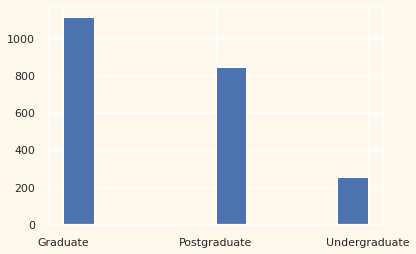

In [ ]:
data['Education'].hist();

In [ ]:
data.describe()

,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,Gold,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Customer_For,Age,Spent,Children,Family_Size,Is_Parent
count,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2.216000e+03,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000
mean,52247.251354,0.441787,0.505415,49.012635,305.091606,26.356047,166.995939,37.637635,27.028881,43.965253,2.323556,4.085289,2.671029,5.800993,5.319043,0.073556,0.074007,0.073105,0.064079,0.013538,0.009477,0.150271,4.423735e+16,52.179603,607.075361,0.947202,2.592509,0.714350
std,25173.076661,0.536896,0.544181,28.948352,337.327920,39.793917,224.283273,54.752082,41.072046,51.815414,1.923716,2.740951,2.926734,3.250785,2.425359,0.261106,0.261842,0.260367,0.244950,0.115588,0.096907,0.357417,2.008532e+16,11.985554,602.900476,0.749062,0.905722,0.451825
min,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,25.000000,5.000000,0.000000,1.000000,0.000000
25%,35303.000000,0.000000,0.000000,24.000000,24.000000,2.000000,16.000000,3.000000,1.000000,9.000000,1.000000,2.000000,0.000000,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.937600e+16,44.000000,69.000000,0.000000,2.000000,0.000000
50%,51381.500000,0.000000,0.000000,49.000000,174.500000,8.000000,68.000000,12.000000,8.000000,24.500000,2.000000,4.000000,2.000000,5.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.432320e+16,51.000000,396.500000,1.000000,3.000000,1.000000
75%,68522.000000,1.000000,1.000000,74.000000,505.000000,33.000000,232.250000,50.000000,33.000000,56.000000,3.000000,6.000000,4.000000,8.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.927040e+16,62.000000,1048.000000,1.000000,3.000000,1.000000
max,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,262.000000,321.000000,15.000000,27.000000,28.000000,13.000000,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,9.184320e+16,128.000000,2525.000000,3.000000,5.000000,1.000000


Reletive Plot of Some Selected Features: A Data Subset


<Figure size 432x288 with 0 Axes>

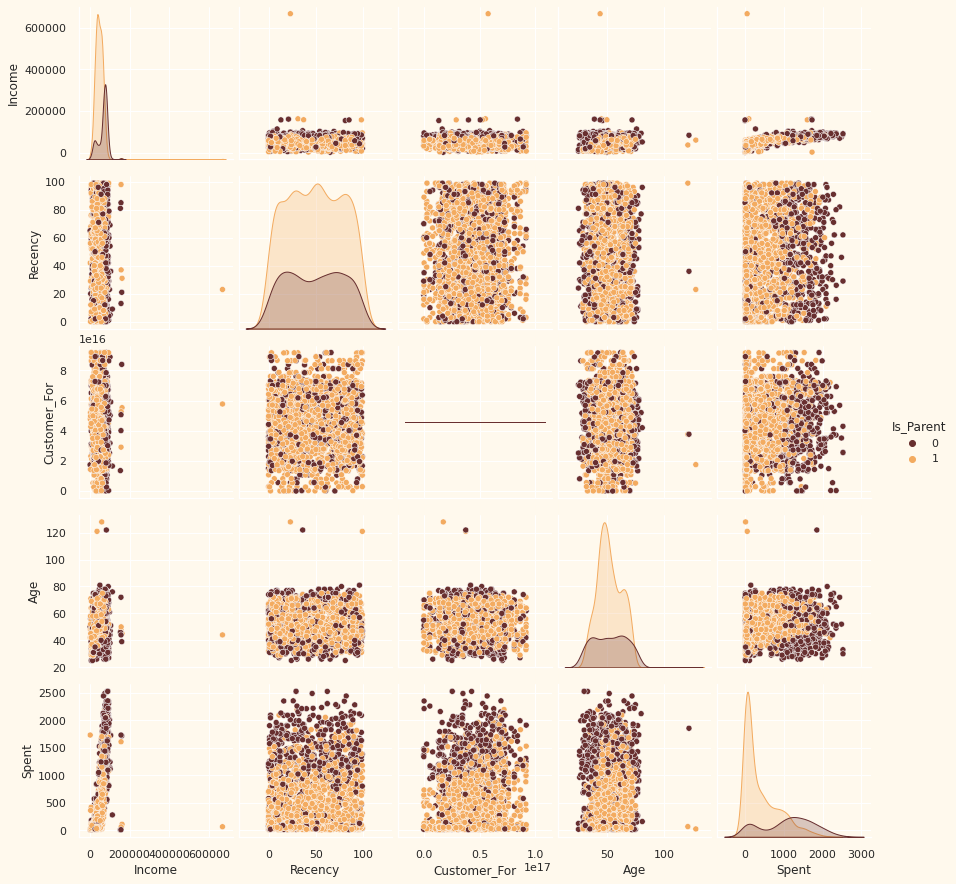

In [ ]:
# To plot some selected features
# Setting up colors preferences
sns.set(rc={
    "axes.facecolor":"#FFF9ED",
    "figure.facecolor":"#FFF9ED"
});
pallet = ["#682F2F", "#9E726F", "#D6B2B1","#B9C0C9", "#9F8A78", "#F3AB60"];
cmap = colors.ListedColormap(pallet);
# Plotting followiing features
To_Plot = ["Income", "Recency", "Customer_For", "Age", "Spent", "Is_Parent"];
print("Reletive Plot of Some Selected Features: A Data Subset");
plt.figure();
sns.pairplot(data[To_Plot], hue="Is_Parent", palette=([
    "#682F2F", "#F3AB60"                                                   
]));
# Taking hue
plt.show();

In [ ]:
# Dropping the outliers by setting a cap on Age and Income
data = data[(data["Age"]<90)]
data = data[(data["Income"]<600000)]
print("The total number of data-points after removing the outliers are:","\n",len(data))

The total number of data-points after removing the outliers are: 
 2212


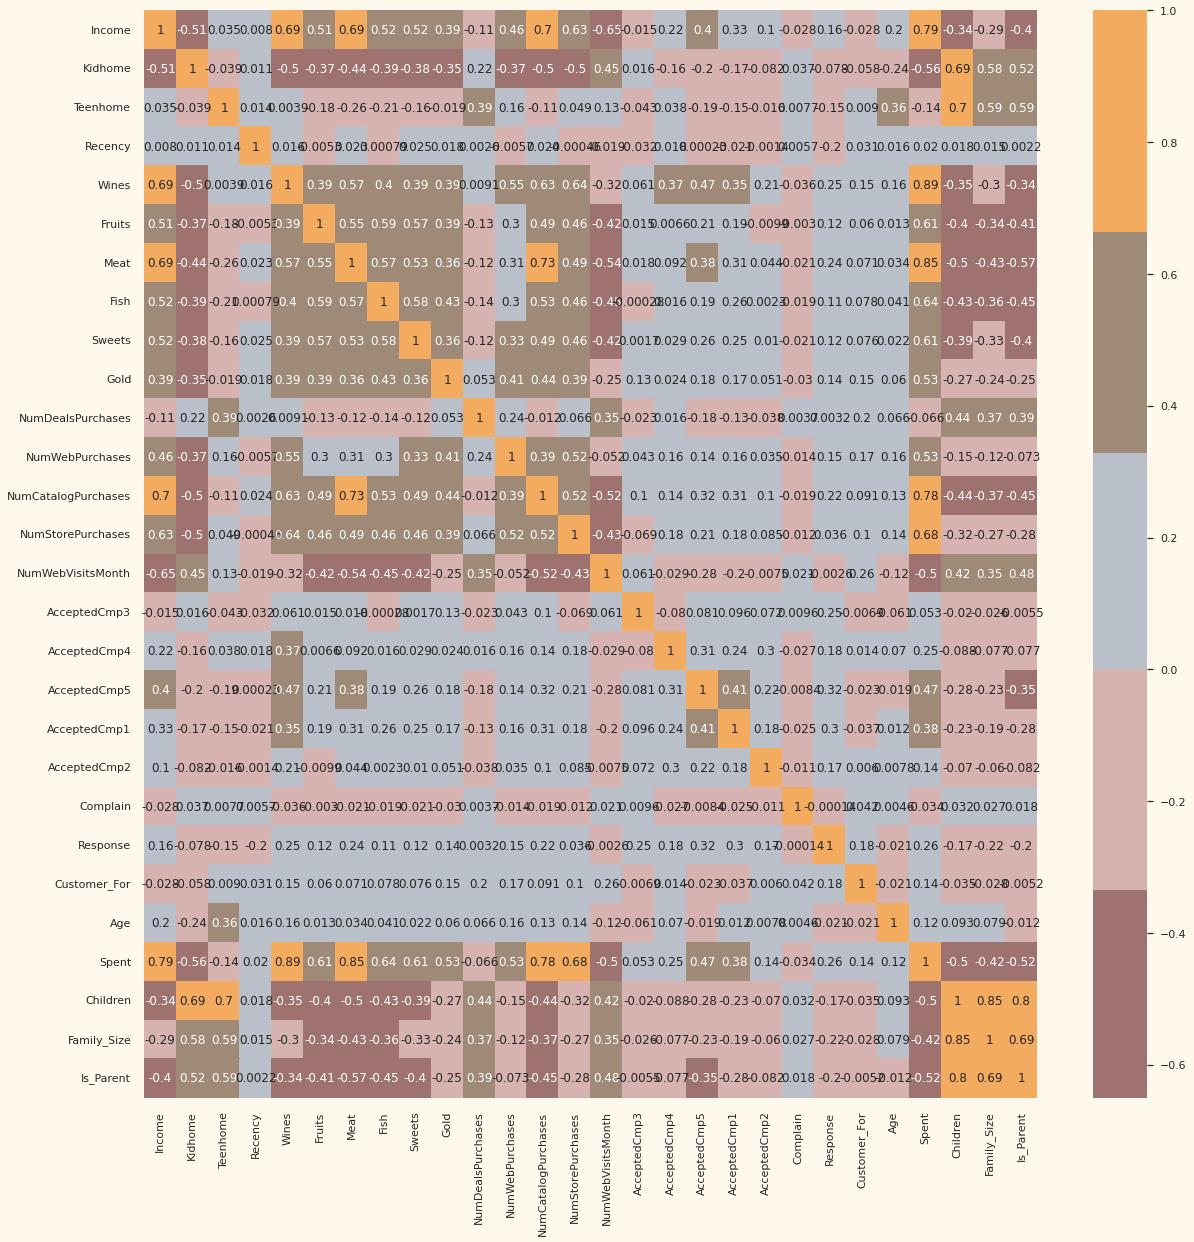

In [ ]:
# Correlation Matrix excluding the categorial attributes 
corrmat = data.corr()
plt.figure(figsize=(20,20));
sns.heatmap(corrmat, annot=True, cmap=cmap, center=0);

# Data Preprocessing 

The data is quite clean and the new features are included. Therefore, we will proceed to the step of: Data Preprocessing

These are the following steps applied to preprocessing the data:    

* Label Encoding the categorial features
* Scaling the features using the standard scaler
* Creating a subset dataframe for dimensionaly reduction

In [ ]:
# Get list of categorical variables 
s = (data.dtypes == 'object')
object_cols = list(s[s].index)

print("Categorical variables in the dataset: ", object_cols)

Categorical variables in the dataset:  ['Education', 'Living_With']


In [ ]:
# Label Encoding the object dtypes.
LE = LabelEncoder()
for i in object_cols:
  data[i] = data[[i]].apply(LE.fit_transform)

print("All features are now numerical")

All features are now numerical


In [ ]:
# Creating a copy of data 
ds = data.copy()
# Creating a subset of dataframe by droping the features on deals accepted and promotions
cols_del = ['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
            'AcceptedCmp2', 'Complain', 'Response']
ds = ds.drop(cols_del, axis=1)
# Scaling
scaler = StandardScaler()
scaler.fit(ds)
scaled_ds = pd.DataFrame(scaler.transform(ds), columns=ds.columns)
print("All features are now scaled")

All features are now scaled


In [ ]:
# Scaled data to be used for reducing the dimensionality
print("Dataframe to be used for further modelling: ")
scaled_ds.head()

Dataframe to be used for further modelling: 


,Education,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,Gold,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Customer_For,Age,Spent,Living_With,Children,Family_Size,Is_Parent
0,-0.893586,0.287105,-0.822754,-0.929699,0.310353,0.977660,1.552041,1.690293,2.453472,1.483713,0.852576,0.351030,1.426865,2.503607,-0.555814,0.692181,1.973583,1.018352,1.676245,-1.349603,-1.264598,-1.758359,-1.581139
1,-0.893586,-0.260882,1.040021,0.908097,-0.380813,-0.872618,-0.637461,-0.718230,-0.651004,-0.634019,-0.733642,-0.168701,-1.126420,-0.571340,-1.171160,-0.132545,-1.665144,1.274785,-0.963297,-1.349603,1.404572,0.449070,0.632456
2,-0.893586,0.913196,-0.822754,-0.929699,-0.795514,0.357935,0.570540,-0.178542,1.339513,-0.147184,-0.037254,-0.688432,1.426865,-0.229679,1.290224,-0.544908,-0.172664,0.334530,0.280110,0.740959,-1.264598,-0.654644,-1.581139
3,-0.893586,-1.176114,1.040021,-0.929699,-0.795514,-0.872618,-0.561961,-0.655787,-0.504911,-0.585335,-0.752987,-0.168701,-0.761665,-0.913000,-0.555814,0.279818,-1.923210,-1.289547,-0.920135,0.740959,0.069987,0.449070,0.632456
4,0.571657,0.294307,1.040021,-0.929699,1.554453,-0.392257,0.419540,-0.218684,0.152508,-0.001133,-0.559545,1.390492,0.332600,0.111982,0.059532,-0.132545,-0.822130,-1.033114,-0.307562,0.740959,0.069987,0.449070,0.632456


# Dimensionality Reduction

In this problem, there are many factors on the basis of which the final classification will be done. These factors are basically attributes or features. The higher the number of features, the harder it is to work with it. 

Many of these features are correlated, and hence redundant. This is why I will be performing dimensionality reduction on the selected features before putting them through a classifier.
Dimensionality reduction is the process of reducing the number of random variables under consideration, by obtaining a set of principal variables.

* **Principal Component Analysis (PCA)** is a technique for reducing the dimnesionality of such datasets, increasing interpretability but at the same time minimizing information loss.

**Steps in this section:**
* Dimensionality Reduction with PCA
* Plotting the reduced dataframe


**Dimensionality Reduction with PCA**

For this project, we will reduce the dimensions to 3.

In [ ]:
# Initiating PCA to reduce dimension AKA features to 3.
pca = PCA(n_components=3)
pca.fit(scaled_ds)
PCA_ds = pd.DataFrame(pca.transform(scaled_ds), columns
                      =(['col1','col2','col3']))
PCA_ds.describe().T

,count,mean,std,min,25%,50%,75%,max
col1,2212.0,-8.612761e-17,2.878377,-5.969394,-2.538494,-0.780421,2.383290,7.444305
col2,2212.0,2.559737e-17,1.706839,-4.312196,-1.328316,-0.158123,1.242289,6.142721
col3,2212.0,4.449425e-17,1.221956,-3.530416,-0.829067,-0.022692,0.799895,6.611222


In [ ]:
PCA_ds

,col1,col2,col3
0,4.994347,-0.151236,2.648081
1,-2.884455,-0.006671,-1.863867
2,2.617864,-0.720757,-0.252088
3,-2.676036,-1.541970,-0.922537
4,-0.649591,0.209831,-0.021196
...,...,...,...
2207,2.321341,2.436323,0.520721
2208,-3.105957,4.020986,-1.499033
2209,2.673666,-1.869183,0.592662
2210,1.494055,1.701859,-1.626902


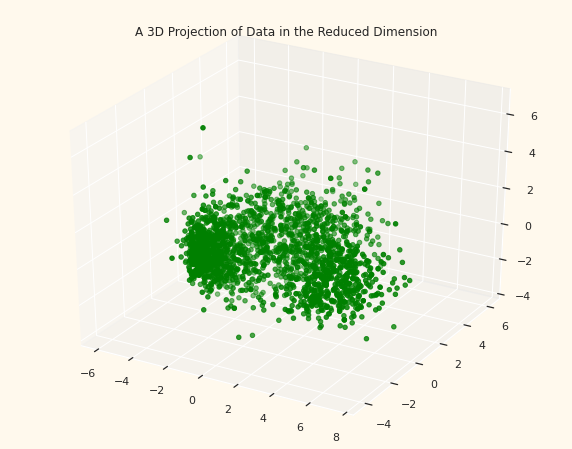

In [ ]:
# A 3D Projection of Data in the Reduced Dimension
x = PCA_ds['col1']
y = PCA_ds['col2']
z = PCA_ds['col3']

# To Plot
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x,y,z, c="green", marker="o")
ax.set_title("A 3D Projection of Data in the Reduced Dimension")
plt.show()

# Clustering

Agglomerative Clustering is a hierarchical clustering method. It involves merging examples until the desired number of clusters is achieved.

**Steps involved in the Clustering**

* Elbow Method to determine the number of clusters to be formed
* Clustering via Agglomerative Clustering 
* Examining the clusters formed via scatter plot

Elbow Method to determine the number of clusters to be formed: 


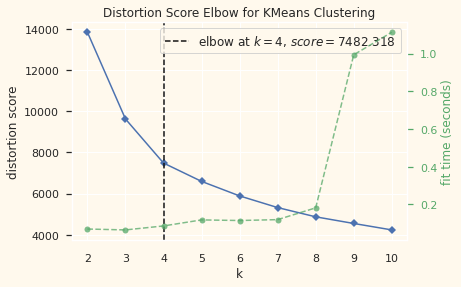

In [ ]:
# Quick examinantion of elbow method to find numbers of clusters to make.
print('Elbow Method to determine the number of clusters to be formed: ')
Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(PCA_ds)
Elbow_M.show();

##### The above cell indicates that **four** will be an optimal number of clusters for this data. Next, we will be fitting the Agglomerative Clustering Model to get the final clusters.

In [ ]:
# Initiating the Agglomerative Clustering Model
AC = AgglomerativeClustering(n_clusters=4)
# fit model and predict clusters
yhat_AC = AC.fit_predict(PCA_ds)
PCA_ds["Clusters"] = yhat_AC
# Adding the Clusters feature to the original dataframe.
data["Clusters"] = yhat_AC

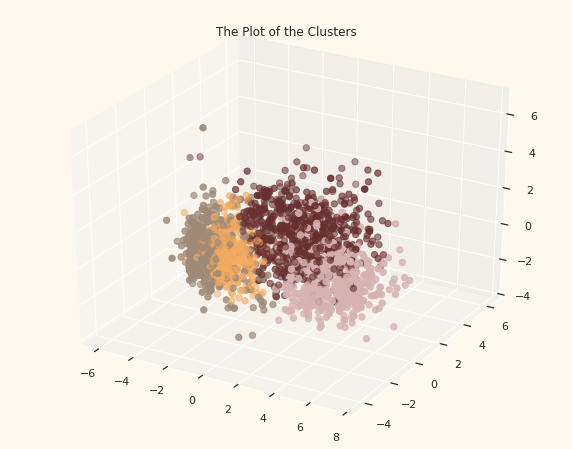

In [ ]:
# 3-D Distribution of the clusters
# Plotting the clusters
fig = plt.figure(figsize=(10, 8))
ax = plt.subplot(111, projection='3d', label='bla')
ax.scatter(x,y,z, s=40, c=PCA_ds["Clusters"], marker='o',
           cmap=cmap)
ax.set_title("The Plot of the Clusters")
plt.show()

# Evaluating Models

Since this is an unsupervised clustering. We do not have a tagged feature to evaluate or score our model. The purpose of this section is to study the patterns in the clusters formed and determine the nature of the clusters' patterns.

For that, we will be ahving a look at the data in light of clusters via exploratory data analysis and drawing conclusions.

**Firstly, let us have a look at the group distribution of clustering**

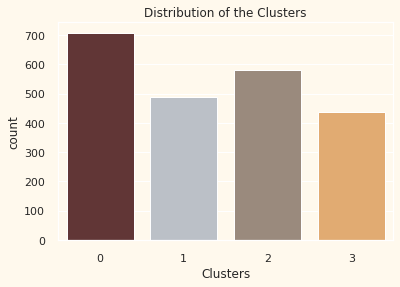

In [ ]:
# Plotting countplot of clusters
pal = ["#682F2F","#B9C0C9", "#9F8A78","#F3AB60"]
pl = sns.countplot(x=data["Clusters"], palette=pal)
pl.set_title("Distribution of the Clusters")
plt.show()

##### The clusters seem to be fairly distributed.

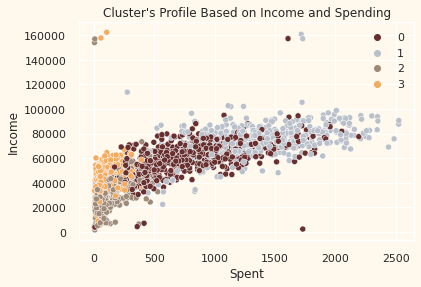

In [ ]:
pl = sns.scatterplot(data=data, x=data["Spent"],
                     y=data['Income'], hue=data["Clusters"],
                     palette=pal)
pl.set_title("Cluster's Profile Based on Income and Spending")
plt.legend()
plt.show()

**Income vs spending plot shows the clusters pattern**

* group 0: high spending and average income.
* group 1: low spending and low income
* group 2: high spending and high income
* group 3: low spending and average income

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 55.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 36.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 83.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 81.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


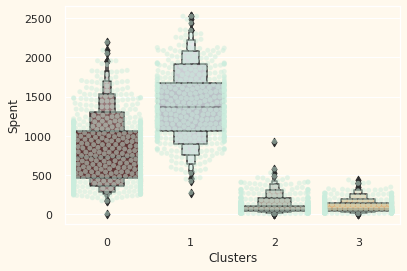

In [ ]:
plt.figure()
pl = sns.swarmplot(x=data["Clusters"], y=data["Spent"],
                   color='#CBEDDD', alpha=0.5)
pl = sns.boxenplot(x=data["Clusters"], y=data["Spent"],
                   palette=pal)
plt.show()

##### Cluster 2 is our biggest set of customers followed by Cluster 0

We can explore what each cluster is spending on for the targeted marketing strategies.

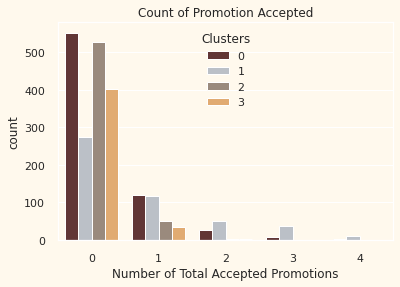

In [ ]:
# Create a feature to get a sum of accepted promotions
data["Total_Promos"] = data["AcceptedCmp1"] + data["AcceptedCmp2"] + data["AcceptedCmp3"] + data["AcceptedCmp4"] + data["AcceptedCmp5"]
# Plotting count of total campaign accepted.
plt.figure()
pl = sns.countplot(x=data["Total_Promos"], hue=data["Clusters"], palette=pal)
pl.set_title("Count of Promotion Accepted")
pl.set_xlabel("Number of Total Accepted Promotions")
plt.show()

There has not been an overwhelming response to the campaigns so far. 
Very few participants overall. Moreover, no one part take in all 5 of them. Perhaps better-targeted and well-planned campaigns are required to boost sales.

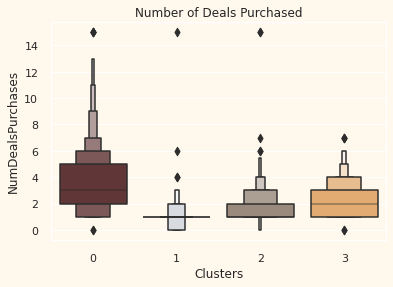

In [ ]:
# Plotting the number of deals purchased
plt.figure()
pl = sns.boxenplot(y=data["NumDealsPurchases"], x=data["Clusters"], palette=pal)
pl.set_title("Number of Deals Purchased")
plt.show()

Each cluster represents a type of customer. That is how the graph needs to be viewed.

# Profiling

Now that we have formed the clusters and looked at their purchasing habits. Let us see who are all there in these clusters. For that, we will be profiling the clusters formed and come to a conslusion about who is our star customer and who needs more attention from the retail store's marketing team.

To decide that I will be plotting some of the features that are indicative of the customer's personal traits in light of the cluster they are in. On the basis of the outcomes, I will be arriving at the conclusions.

<Figure size 432x288 with 0 Axes>

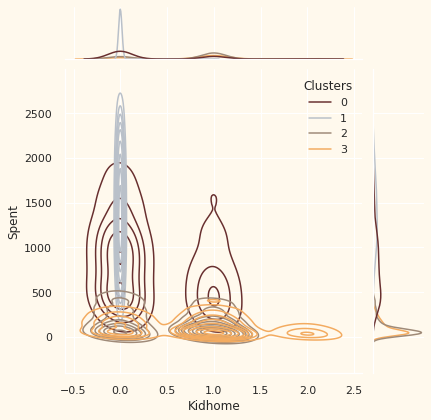

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


<Figure size 432x288 with 0 Axes>

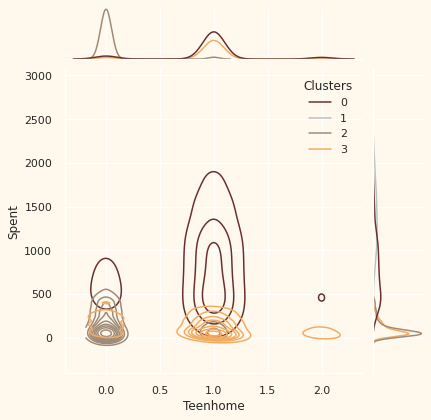

<Figure size 432x288 with 0 Axes>

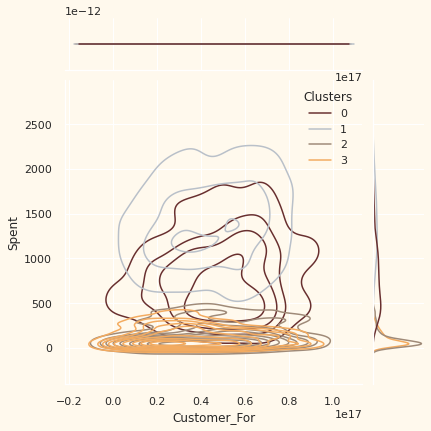

<Figure size 432x288 with 0 Axes>

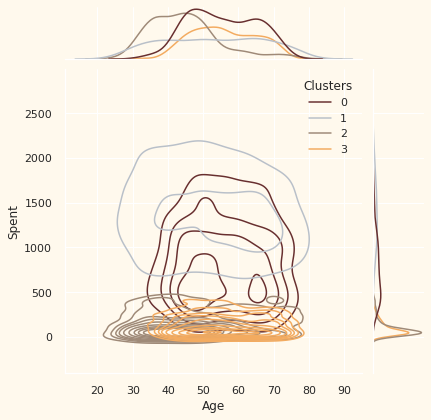

<Figure size 432x288 with 0 Axes>

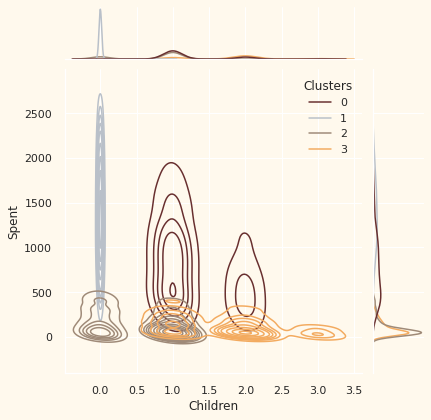

<Figure size 432x288 with 0 Axes>

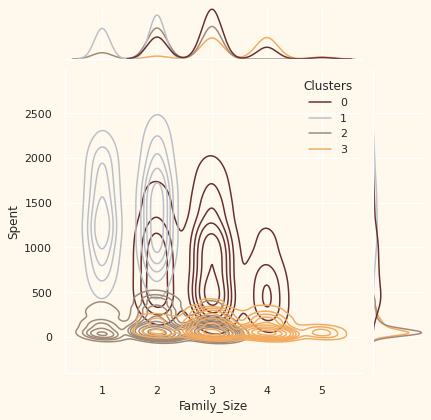

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


<Figure size 432x288 with 0 Axes>

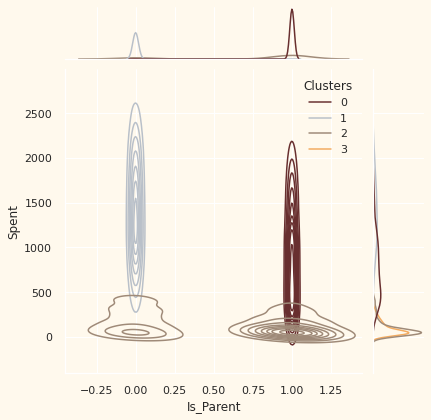

<Figure size 432x288 with 0 Axes>

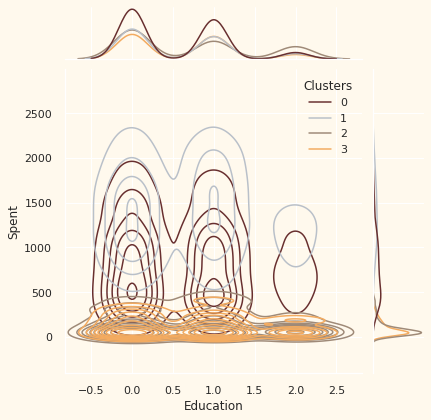

<Figure size 432x288 with 0 Axes>

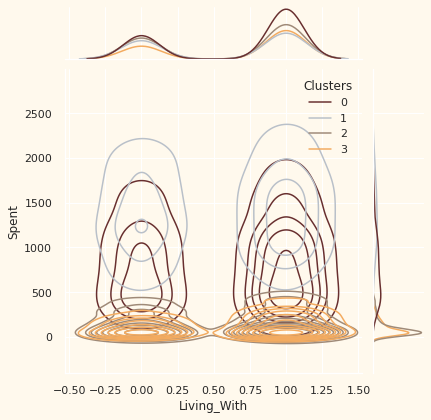

In [ ]:
Personal = ["Kidhome", "Teenhome", "Customer_For",
            "Age", "Children", "Family_Size", "Is_Parent", "Education",
            "Living_With"]

for i in Personal:
  plt.figure();
  sns.jointplot(x=data[i], y=data["Spent"], hue=data["Clusters"],
               kind="kde", palette=pal)
  plt.show();